In [9]:
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import matplotlib.pylab as plt
import matplotlib

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
reshape_dims = [IMG_HEIGHT,IMG_WIDTH]
BATCH_SIZE = 32

CLASS_NAMES = ['roses', 'sunflowers', 'daisy', 'dandelion', 'tulips']

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


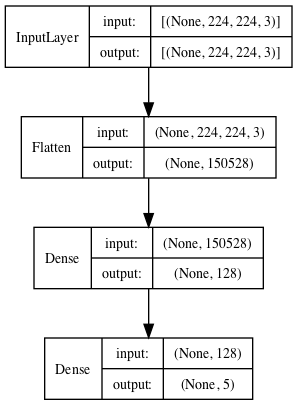

In [10]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               19267712  
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________


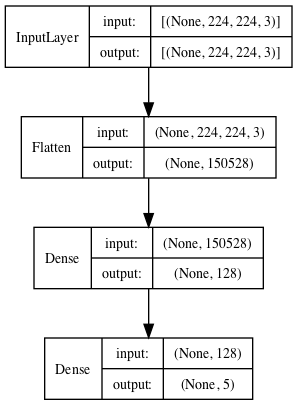

In [11]:
model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation = 'relu'),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

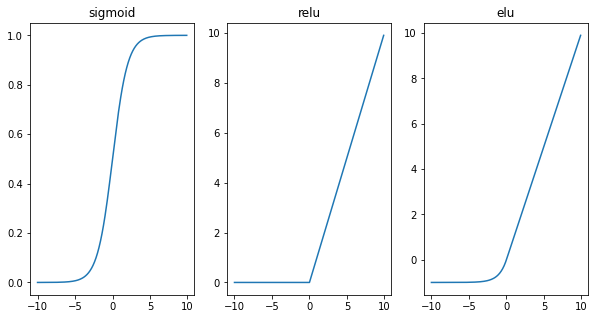

In [12]:
#plot Sigmoid, Relu, Elu nonlinear function
fig, ax = plt.subplots(1, 3, figsize=(10,5))
x = np.arange(-10.0, 10.0, 0.1)
y = tf.keras.activations.sigmoid(x)
ax[0].plot(x, y);
ax[0].set_title("sigmoid")
y = tf.keras.activations.relu(x)
ax[1].plot(x, y);
ax[1].set_title("relu")
y = tf.keras.activations.elu(x)
ax[2].plot(x, y);
ax[2].set_title("elu");

In [13]:
def read_and_decode(filename, reshape_dims):
  # 1.Read the file
  img = tf.io.read_file(filename)

  # 2.Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)

  # 3.Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # 4.Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  #to find the only True label
  return img, label

#plot Training metrics
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

#Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).map(decode_csv))

  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))


In [14]:
train_dataset = (tf.data.TextLineDataset('/Users/zhuzhirui/.keras/datasets/flower_photos/train_set.csv')
                 .map(decode_csv)).batch(BATCH_SIZE)

eval_dataset = (tf.data.TextLineDataset("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")
                .map(decode_csv)).batch(BATCH_SIZE)

model = tf.keras.Sequential([
   tf.keras.layers.Flatten(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)),
   tf.keras.layers.Dense(128, activation= tf.keras.activations.relu),
   tf.keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               19267712  
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 19,268,357
Trainable params: 19,268,357
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
104/104 [==============================] - 9s 86ms/step - loss: 15.8738 - accuracy: 0.3141 - val_loss: 8.9588 - val_accuracy: 0.3333
Epoch 2/10
104/104 [==============================] - 9s 83ms/step - loss: 6.2312 - accuracy: 0.3996 - val_loss: 6.3939 - val_accuracy: 0.3306
Epoch 3/10
104/104 [==============================] - 9s 83ms/step - loss: 5.9937 - a

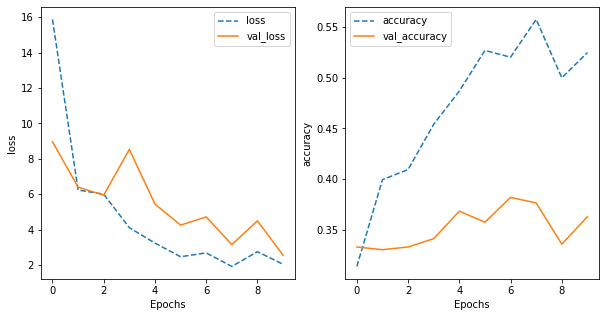

In [15]:
training_plot(['loss', 'accuracy'], history)

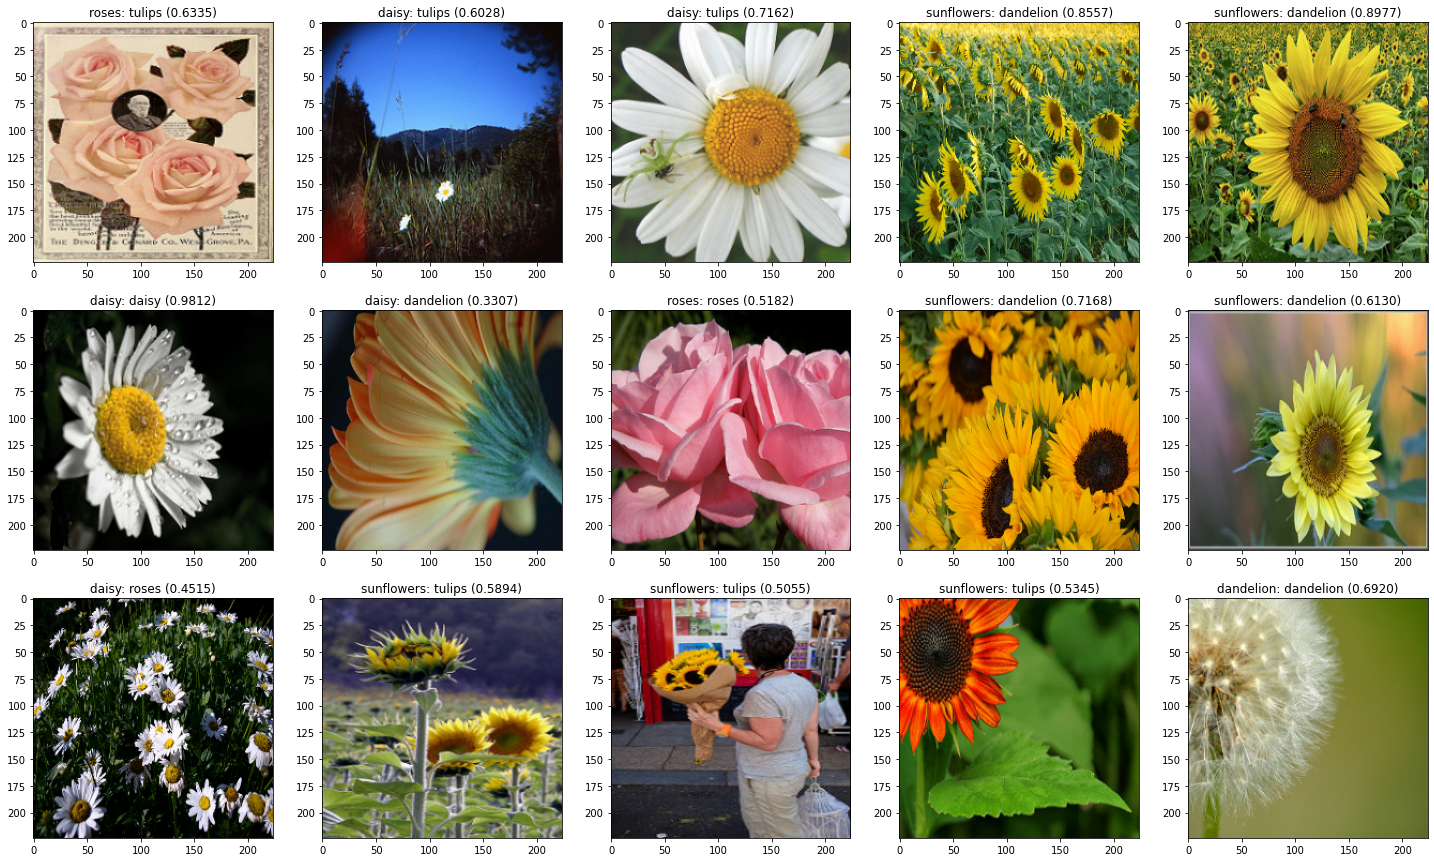

In [16]:
plot_predictions("/Users/zhuzhirui/.keras/datasets/flower_photos/eval_set.csv")

In [17]:
#change learning rate to 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
104/104 [==============================] - 10s 88ms/step - loss: 0.8854 - accuracy: 0.6919 - val_loss: 1.8881 - val_accuracy: 0.3875
Epoch 2/10
104/104 [==============================] - 9s 86ms/step - loss: 0.7976 - accuracy: 0.7131 - val_loss: 1.8325 - val_accuracy: 0.4119
Epoch 3/10
104/104 [==============================] - 9s 85ms/step - loss: 0.7563 - accuracy: 0.7295 - val_loss: 1.8377 - val_accuracy: 0.3902
Epoch 4/10
104/104 [==============================] - 9s 84ms/step - loss: 0.7216 - accuracy: 0.7531 - val_loss: 1.7942 - val_accuracy: 0.3957
Epoch 5/10
104/104 [==============================] - 9s 85ms/step - loss: 0.7026 - accuracy: 0.7595 - val_loss: 1.8738 - val_accuracy: 0.3957
Epoch 6/10
104/104 [==============================] - 9s 87ms/step - loss: 0.6758 - accuracy: 0.7683 - val_loss: 1.7935 - val_accuracy: 0.3848
Epoch 7/10
104/104 [==============================] - 9s 82ms/step - loss: 0.6583 - accuracy: 0.7749 - val_loss: 1.7820 - val_accuracy: 0.403

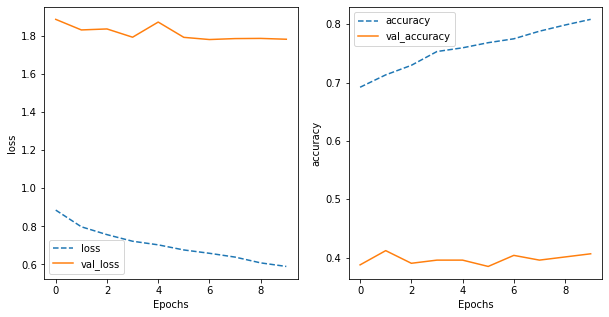

In [18]:
training_plot(['loss', 'accuracy'], history)